In [1]:
import math

import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import Datasets

## Carga de los datos

In [2]:
mne.set_log_level(verbose=False)

In [3]:
dataset = Datasets.EDFData_TF("../Data/PSG1.edf", batch_size=8, channels=['F4'])
dataset_2 = Datasets.EDFData_TF("../Data/PSG2.edf", batch_size=8, channels=['F4'])

e:\Python\TFM\SSD_IA3\Notebooks\Datasets.py:18: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path)
e:\Python\TFM\SSD_IA3\Notebooks\Datasets.py:18: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(path)
e:\Python\TFM\SSD_IA3\Notebooks\Datasets.py:18: RuntimeWarning: Omitted 6 annotation(s) that were outside data range.
  data = mne.io.read_raw_edf(path)
e:\Python\TFM\SSD_IA3\Notebooks\Datasets.py:18: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(path)


In [4]:
dataset.epochs.ch_names

['F4']

In [5]:
dataset.epochs

<Epochs |  882 events (all good), 0 - 29.998 sec, baseline off, ~6 kB, data not loaded,
 'Sleep stage N1': 25
 'Sleep stage N2': 317
 'Sleep stage N3': 193
 'Sleep stage R': 101
 'Sleep stage W': 246>

In [6]:
len(dataset)

111

In [7]:
for a, b in dataset:
    break

In [8]:
a.shape, b.shape

((8, 1, 15360), (8,))

## Exploration

In [9]:
dataset.epochs.load_data()

<Epochs |  882 events (all good), 0 - 29.998 sec, baseline off, ~103.4 MB, data loaded,
 'Sleep stage N1': 25
 'Sleep stage N2': 317
 'Sleep stage N3': 193
 'Sleep stage R': 101
 'Sleep stage W': 246>

In [10]:
dataset_2.epochs.load_data()

<Epochs |  840 events (all good), 0 - 29.998 sec, baseline off, ~98.4 MB, data loaded,
 'Sleep stage N1': 63
 'Sleep stage N2': 388
 'Sleep stage N3': 235
 'Sleep stage R': 136
 'Sleep stage W': 18>

In [11]:
data = np.squeeze(dataset.epochs._data)
data.shape

(882, 15360)

In [12]:
data_2 = np.squeeze(dataset_2.epochs._data)
data_2.shape

(840, 15360)

In [13]:
labels = []
for a,b in dataset:
    labels.extend(b)
labels = np.array(labels)
labels.shape

(882,)

In [14]:
labels_2 = []
for a,b in dataset_2:
    labels_2.extend(b)
labels_2 = np.array(labels_2)
labels_2.shape

(840,)

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
std = StandardScaler()

In [17]:
std.fit(data)
data_std = std.transform(data)
data_2_std = std.transform(data_2)

In [18]:
dataset.id_to_class_dict

{0: 'Sleep stage N1',
 1: 'Sleep stage N2',
 2: 'Sleep stage N3',
 3: 'Sleep stage R',
 4: 'Sleep stage W'}

In [19]:
dataset_2.id_to_class_dict

{0: 'Sleep stage N1',
 1: 'Sleep stage N2',
 2: 'Sleep stage N3',
 3: 'Sleep stage R',
 4: 'Sleep stage W'}

## Model

In [20]:
sr = int(dataset.sampling_rate)
sr

512

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=sr//2, padding='same', strides=sr//4, activation="relu", data_format='channels_first', 
    input_shape=(len(dataset.channels),15360)),
    tf.keras.layers.MaxPooling1D(8),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(128, kernel_size=8, padding='same', strides=1, activation="relu", data_format='channels_first'),
    tf.keras.layers.Conv1D(128, kernel_size=8, padding='same', strides=1, activation="relu", data_format='channels_first'),
    tf.keras.layers.Conv1D(128, kernel_size=8, padding='same', strides=1, activation="relu", data_format='channels_first'),
    tf.keras.layers.MaxPooling1D(4),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation="softmax")
])

In [22]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 120)          32896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 120)           0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 120)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 120)          16512     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 120)          131200    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 120)          131200    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 120)           0

In [23]:
history = model.fit(np.expand_dims(data_std,1), labels, epochs=50, validation_data=(np.expand_dims(data_2_std,1), labels_2))

Epoch 1/50
28/28 [==============================] - 2s 54ms/step - loss: 1.5025 - accuracy: 0.3152 - val_loss: 1.5517 - val_accuracy: 0.4119
Epoch 2/50
28/28 [==============================] - 0s 15ms/step - loss: 1.4353 - accuracy: 0.3549 - val_loss: 1.5399 - val_accuracy: 0.4607
Epoch 3/50
28/28 [==============================] - 0s 15ms/step - loss: 1.4085 - accuracy: 0.3991 - val_loss: 1.5068 - val_accuracy: 0.4595
Epoch 4/50
28/28 [==============================] - 0s 15ms/step - loss: 1.4145 - accuracy: 0.3617 - val_loss: 1.5714 - val_accuracy: 0.2714
Epoch 5/50
28/28 [==============================] - 0s 15ms/step - loss: 1.4128 - accuracy: 0.3651 - val_loss: 1.6138 - val_accuracy: 0.1714
Epoch 6/50
28/28 [==============================] - 0s 15ms/step - loss: 1.3987 - accuracy: 0.3764 - val_loss: 1.7486 - val_accuracy: 0.0238
Epoch 7/50
28/28 [==============================] - 0s 15ms/step - loss: 1.3850 - accuracy: 0.4206 - val_loss: 2.3868 - val_accuracy: 0.0286
Epoch 8/50
28

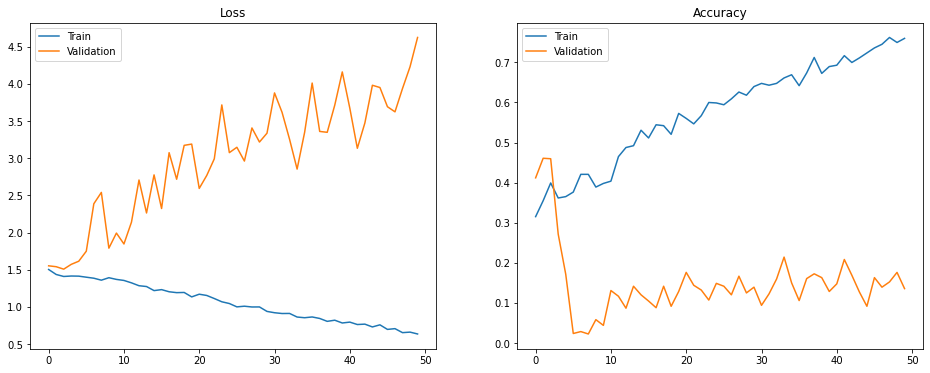

In [24]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend()
plt.show()